# Example using scidat: Download Annotate TCGA

This was designed to be a simple interface that allows for downloading and annotating data from TCGA.


## Section 1: Data selection and metadata download

Download metatdata from TCGA.
For this program to work you need to first go to: https://portal.gdc.cancer.gov/ and select the files to download.

In this example, I chose my data by using the following steps:
    1. Navigate to `Exploration` tab
    2. Selected `kidney` as the Primary Site
    3. Selected `solid tissue normal` and `primary tumor` for my Sample Type (823 cases)
    4. Selected `KIRP` as the project (279 cases)
    5. Selected `dead` as the vital status (43 cases)
    6. Clicked `View Files in Repository`
    
Since I'm only interested in RNAseq count data and Methylation beta values, I filter my files to only include these two types of files.   
    7. Selected `RNA-seq` as my Experimental Strategy
    8. Selected `HTSeq - Counts` in Workflow Type
    9. Clicked `Add all files to cart` (50 files, 43 cases)
    
link: https://portal.gdc.cancer.gov/repository?filters=%7B%22op%22%3A%22and%22%2C%22content%22%3A%5B%7B%22content%22%3A%7B%22field%22%3A%22cases.case_id%22%2C%22value%22%3A%5B%22set_id%3AAXGBi619om_VEIzbp9eW%22%5D%7D%2C%22op%22%3A%22IN%22%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22files.analysis.workflow_type%22%2C%22value%22%3A%5B%22HTSeq%20-%20Counts%22%5D%7D%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22files.experimental_strategy%22%2C%22value%22%3A%5B%22RNA-Seq%22%5D%7D%7D%5D%7D

Now I navigated to my cart which had 50 files in it. Since it is recomended to use th GDC-data transfer tool (which scidat uses) I only download the `manifest` and the `metadata` for my files of interest.
Before proceeding, look at how much space the files will need (e.g. for me this is 12.62MB) make sure the computer you are downloading on has that space available.

### Download: 
    13. `Biospecimen` (tsv)
    14. `Clinical` (tsv)
    15. `Sample Sheet`
    16. `Metadata`
    17. Click the `Download` button and select `Manifest`

Last steps:
     1. Lastly, move all these files to a new empty directory `~/Documents/TCGA_data_download_scidat/`. 
     2. Unzip the `Clinical` folder and delete the zipped version.
     3. Copy the `clinical.tsv` file in the `clinical.cart....` folder to the `~/Documents/TCGA_data_download_scidat/` directory.
     4. Make a new directory in `~/Documents/TCGA_data_download_scidat/` called `downloads` (we'll use this below)

## Get GDC Data Transfer Tool
If you haven't already got the GDC transfer tool, you'll need to download this, follow the instructions from TCGA on how to do this:
https://gdc.cancer.gov/access-data/gdc-data-transfer-tool

(choose the correct version of the below 3 for your system)
Package icongdc-client_v1.5.0_Windows_x64.zip
Package icongdc-client_v1.5.0_Ubuntu_x64.zip
Package icongdc-client_v1.5.0_OSX_x64.zip


Unzip and move the downloaded GDC transfer tool to the same directory you put your manifest file in i.e. `~/Documents/TCGA_data_download_scidat/` from before.
Now we're ready to download the files and annotate them with the data we downloaded.
    

## Section 2: File download

The script below assumes you have put the files from above in `~/Documents/TCGA_data_download_scidat/` and that your `gdc-client` is executable.

If you are using a windows machine (or put your files in a different folder you'll need to rename that directory).

Before running the script below you will need to make sure you have edited the path to the manifest file, and the gdc_client to be located where you placed them on your computer and with their proper names
(e.g. 

In [1]:
from scidat import API


"""
This will take about 3 minutes so sit back and have a coffee!

Note if you have a very large amount of data to download you should increase the max_cnt. 
This will run a process for each 5 cases, i.e. if your downloading 5000 files, that will be 1000 processes!

"""
meta_dir = '/Users/ariane/Documents/TCGA_data_download_scidat/'
manifest_file = f'{meta_dir}gdc_manifest_20200416_055430.txt'
gdc_client = f'{meta_dir}./gdc-client'
download_dir = f'{meta_dir}downloads/'

clinical_file = f'{meta_dir}clinical.tsv'
sample_file = f'{meta_dir}gdc_sample_sheet.2020-04-16.tsv'

# scidat spits the manifest file into submanifests so that we can make multiple calls to TCGA simulateously.
# This speeds up the download process. Note, it will use up more of your computers' processing so if you are worried
# just set the max_cnt to be more than the number of files in your manifest e.g. 100000000
api = API(manifest_file, gdc_client, clinical_file, sample_file, requires_lst=None, clin_cols=None,
          max_cnt=5, sciutil=None, split_manifest_dir=download_dir, download_dir=download_dir,
          meta_dir=meta_dir, sep='_')

api.download_data_from_manifest()


## Section 3: Clinical information annotation

Here we are going to builld the clinical information dataframe.

We're also interested in the mutation data so we're going to download the mutation data.

In [2]:
from scidat.api import API

"""
This section will take about 30 second to 1 min
"""

# Build the annotation
api.build_annotation()

# Download the mutation data --> here we can pass only some case IDs or if we leave it empty we download all the 
# mutation data for our cases.
api.download_mutation_data()


--------------------------------------------------------------------------------
                              Clinical dataframe	                               
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
   submitter_id project_id  age_at_index  gender                       race  \
0  TCGA-G7-6793  TCGA-KIRP            60  female                      white   
2  TCGA-A4-7585  TCGA-KIRP            67    male                      white   
4  TCGA-AL-3466  TCGA-KIRP            41    male                      white   
6  TCGA-J7-8537  TCGA-KIRP            37  female                      asian   
8  TCGA-BQ-5877  TCGA-KIRP            60    male  black or african american   

  vital_status tumor_stage  
0         Dead    stage iv  
2         Dead   stage iii  
4         Dead    stage iv  
6         Dead   stage iii  
8         Dead    stage iv  	
--------------------------

In [3]:
# Now we can do all sorts of things for example get cases with specific metadata
# Now we want to check the functionality we expect
metadata = {'race': ['white'], 'gender': ['male'], 'project_id': ['TCGA-KIRP']}

cases = api.get_cases_with_meta(metadata, "all")
cases.sort()
print(len(cases))

24


## Section 4: Annotation with mutation data

Unfortunately TCGA doesn't make it easy to add the mutation annotation data. 

If in **Section 1** you didn't do the optional *step 5* please go back and download the mutation data as we need this to add the mutation information.

How this section works is that we have the different mutations (the file we downloaded from **Section 1** has the mutation ID and the information about the specific mutation. Unfortunatly, this isn't connected to a case (patient). In order to connect the mutation with the patient we need to call the API provided by TCGA (https://docs.gdc.cancer.gov/API/Users_Guide/Data_Analysis/#simple-somatic-mutation-endpoint-examples).

In [4]:
# First lets build the mutation DF
api.build_mutation_df()

# Lets get all the genes with mutations
genes = api.get_genes_with_mutations()
print(len(genes))

3090


## Look at the data and add gene names

Here we build the RNAseq dataframe. Since TCGA gives us the genes identified by their Ensembl ID, we want to annotate these with their `gene symbol`. We do this by using biomart.

This section will take some time as we're going to be downloading the annotation information from biomart.

Note you won't have to do this everytime! It will just be the first time when you are creating this reference file.



In [8]:
from sciutil import Biomart

# Build the RNAseq dataframe
api.build_rna_df(download_dir)

# Now we need to access biomart to be able to mix between the two (i.e. one is annotated with gene symbol the other has ens id)
df = api.get_rna_df()

bm = Biomart()
df = api.get_rna_df()

# Check if we've already downloaded the information
gene_annotation_file = None # Note you should set this if you've already run this notebook!! 

"""

If you need to download the gene annotation information this will take more time. est: 6 minutes


"""
if gene_annotation_file is None:
    # Set the gene annotation filename
    gene_annotation_file = api.u.generate_label([meta_dir, 'gene_info'], '.tsv')
    bm.build_gene_info_file('hsapiens_gene_ensembl', None, meta_dir)

# Now we want to create the actual annotation dictionary
bm.build_gene_annot_dict(gene_annotation_file)

# Now we want to add our annotation data to our dataframe
# The first parameter is our dataframe, then the second parameter is whether we want to drop rows with null values
# We'll drop these rows since we only want data that has full metadata (i.e. go terms etc)
df = bm.add_gene_metadata_to_df(df, True)

--------------------------------------------------------------------------------
Sorted our gene information, gene dictionary length: 	62660	
 Error log: 	 chr: 	40990		 end: 	18		 start: 	356	
--------------------------------------------------------------------------------


## Example 1: Calculating the logfold change accross 2 conditions
Since the data from TCGA is just raw counts, we want to first normalise it. Usually I would use normalisations from DeSeq2, but for this tutorial we'll just log transform counts + 1.

Here we'll pretend to be interested in how female KIRC and male KIRC samples differ. To do this, we'll first calculate the log fold change between the two conditions. Then to see if there are any outlier genes, we'll have a look at a volcano plot of the data.




No handles with labels found to put in legend.


2
3
                                             Samples     Values Conditions
0  NF2-MUT_TCGA-KIRP_PrimaryTumor_female_white_3_...  10.788718    NF2-MUT
1  NF2-MUT_TCGA-KIRP_SolidTissueNormal_male_black...  12.998943    NF2-MUT
2  NF2-MUT_TCGA-KIRP_PrimaryTumor_male_blackorafr...  12.209453    NF2-MUT
3  MET-MUT_TCGA-KIRP_PrimaryTumor_male_white_1_No...  11.275543    MET-MUT
4  MET-MUT_TCGA-KIRP_PrimaryTumor_male_notreporte...  12.504322    MET-MUT


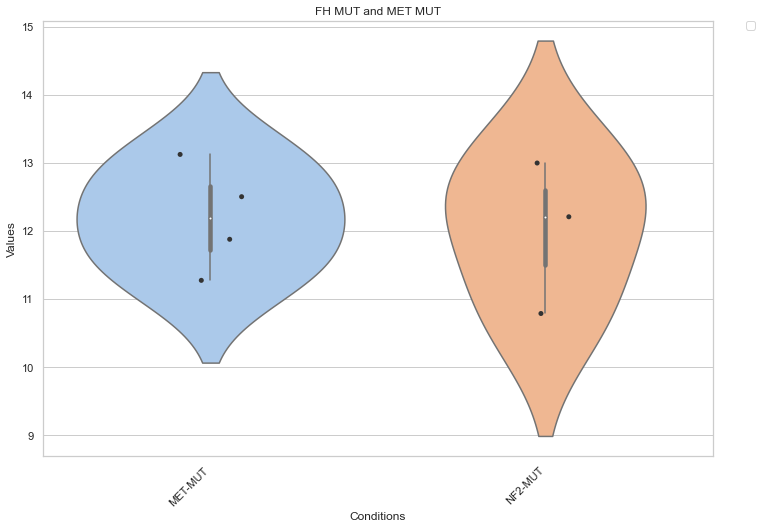

In [12]:
from sciviso import Boxplot, Violinplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filter_col = 'ssm.consequence.0.transcript.gene.symbol'
column_returned = "case_id"
genes_of_interest = ['FH', 'SDHB', 'SDHA', 'SDHC', 'SDHD', 'MET', 'ATF4', 'CHAC1', 'PSAT1', 'NRF2', 'SLC7A11', 'CDKN1A']
NF2_mutations = api.get_mutation_values_on_filter(column_returned, ['NF2'], filter_col)

transformed_df = pd.DataFrame()
print(len(fh_mutations))
values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', NF2_mutations)
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['NF2-MUT_' + c] = np.log2(filtered_df[c].values + 1)
        
met_mutations = api.get_mutation_values_on_filter(column_returned, ['MET'], filter_col)
print(len(met_mutations))
values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', met_mutations)
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['MET-MUT_' + c] = np.log2(filtered_df[c].values + 1)

# Now lets calculate the changes between two conditions, let's go with KIRC vs KIRP
transformed_df['gene_id'] = df['gene_id'].values

boxplot = Boxplot(transformed_df, None, None)
box_df = boxplot.format_data_for_boxplot(transformed_df, ['NF2-MUT', 'MET-MUT'], "gene_id", ["FH"])
print(box_df.head())
boxplot = Violinplot(box_df, "Conditions", "Values", "FH MUT and MET MUT", add_dots=True)
boxplot.plot()
plt.show()

# Here normally we would run edgeR or deseq2 but we're just going to do a simple wilcoxin signed rank test between KIRP and KIRC for these conditions



## Example 2: Looking at differences across genes between conditions
Here we have selected a group of genes and we're interested in how specifc cases change across these genes. For this, we'll use the log transformed data. Here we look at a box plot of each condition on the x axis and the y-values are the values for these conditions.

submitter_id
project_id
age_at_index
gender
race
vital_status
tumor_stage
normal_samples
tumor_samples
case_files
tumor_stage_num

SolidTissueNormal vs PrimaryTumor

For this, we're just going to make two plots, a violin plot of the KIRP dataset for a set of genes and the KIRC
we're going to be looking at the normal tissue compared with the shape of the tumour tissue

No handles with labels found to put in legend.


                                             Samples     Values   Conditions
0  KIRP-NORMAL_TCGA-KIRP_SolidTissueNormal_male_w...  11.214926  KIRP-NORMAL
1  KIRP-NORMAL_TCGA-KIRP_SolidTissueNormal_male_b...  12.998943  KIRP-NORMAL
2  KIRP-NORMAL_TCGA-KIRP_SolidTissueNormal_male_w...  12.028597  KIRP-NORMAL
3  KIRP-NORMAL_TCGA-KIRP_SolidTissueNormal_male_n...  13.125091  KIRP-NORMAL
4  KIRP-TUMOUR_TCGA-KIRP_PrimaryTumor_male_blacko...  10.126704  KIRP-TUMOUR


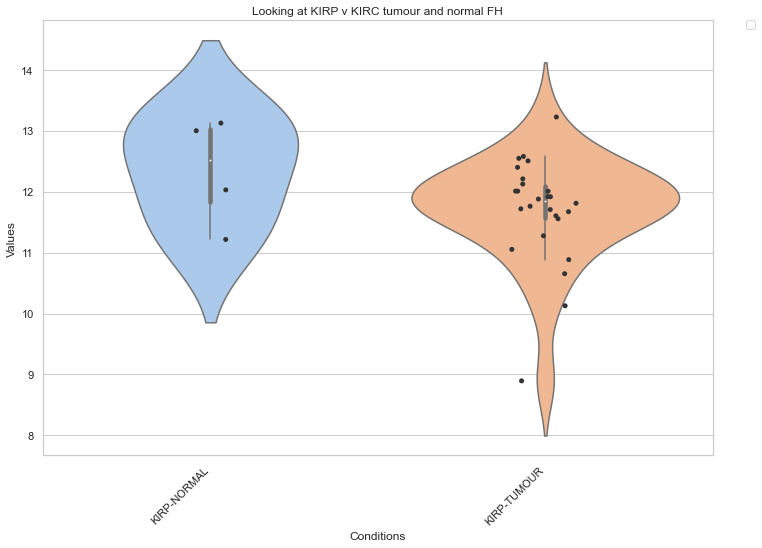

In [13]:


male_KIRP = api.get_cases_with_meta({'gender': ['male'], 'tumor_stage_num': [1, 2, 3, 4], 'project_id': ['TCGA-KIRP']})
male_KIRC = api.get_cases_with_meta({'gender': ['male'], 'tumor_stage_num': [1, 2, 3, 4], 'project_id': ['TCGA-KIRC']})

transformed_df = pd.DataFrame()

# Here we're going to get a couple of groups of data, first the KIRP normal
values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', male_KIRP, None, column_name_includes=["SolidTissueNormal"])
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['KIRP-NORMAL_' + c] = np.log2(filtered_df[c].values + 1)
values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', male_KIRP, None, column_name_includes=["PrimaryTumor"])
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['KIRP-TUMOUR_' + c] = np.log2(filtered_df[c].values + 1)
        
values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', male_KIRC, None, column_name_includes=["SolidTissueNormal"])
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['KIRC-NORMAL_' + c] = np.log2(filtered_df[c].values + 1)
values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', male_KIRC, None, column_name_includes=["PrimaryTumor"])
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['KIRC-TUMOUR_' + c] = np.log2(filtered_df[c].values + 1)


transformed_df['gene_id'] = df['gene_id'].values

boxplot = Boxplot(transformed_df, None, None)
box_df = boxplot.format_data_for_boxplot(transformed_df, ['KIRP-TUMOUR', 'KIRP-NORMAL', 'KIRC-NORMAL', 'KIRC-TUMOUR'], "gene_id", ["FH"])
print(box_df.head())
boxplot = Violinplot(box_df, "Conditions", "Values", "Looking at KIRP v KIRC tumour and normal FH", add_dots=True)
boxplot.plot()
plt.show()
        


## Example 3: Looking at genes across conditions
Here we may have a hypothesis related to how a specific gene changes across multiple conditions. For this, we may want to look at a box plot of the genes on the x-axis and the values of that gene from the different samples as the y axis.



No handles with labels found to put in legend.


['TSPAN6' 'TNMD' 'DPM1' ... None None None]
(60488, 9)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EARLY_STAGE v.s. LATE_STAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.696e-01 U_stat=2.300e+01


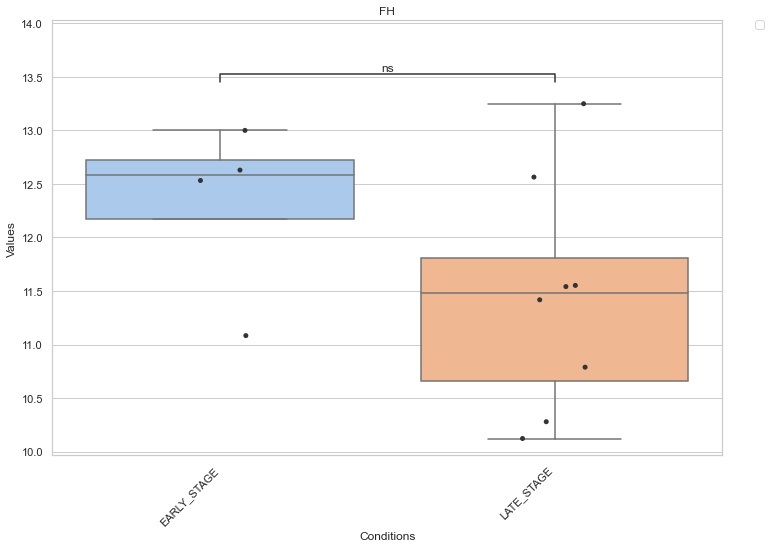

No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EARLY_STAGE v.s. LATE_STAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.522e-01 U_stat=2.000e+01


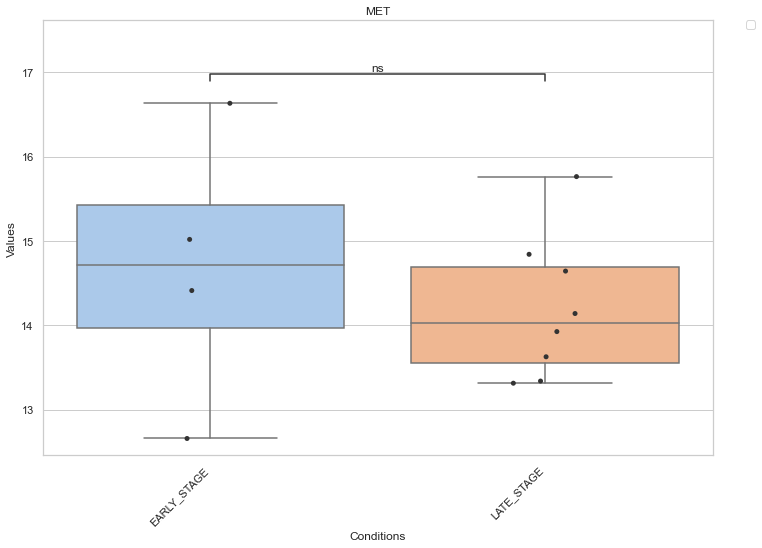

p-value annotation legend:

No handles with labels found to put in legend.



ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EARLY_STAGE v.s. LATE_STAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.502e-01 U_stat=1.000e+01


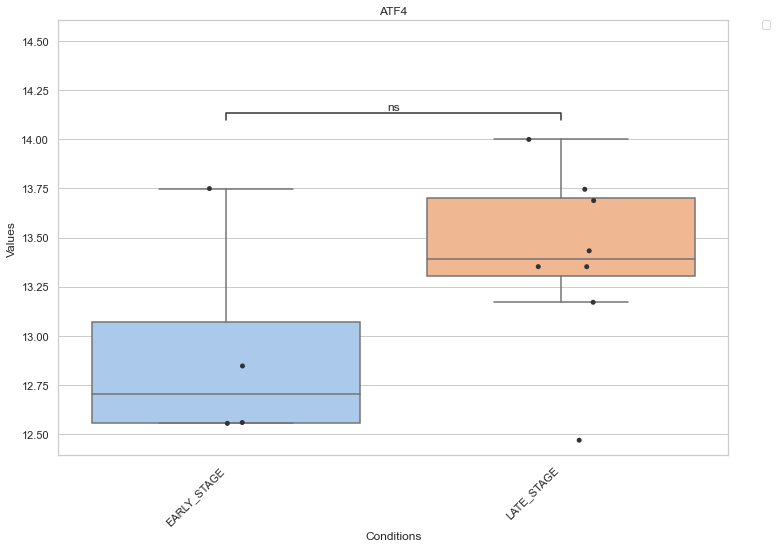

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EARLY_STAGE v.s. LATE_STAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.522e-01 U_stat=1.200e+01


No handles with labels found to put in legend.


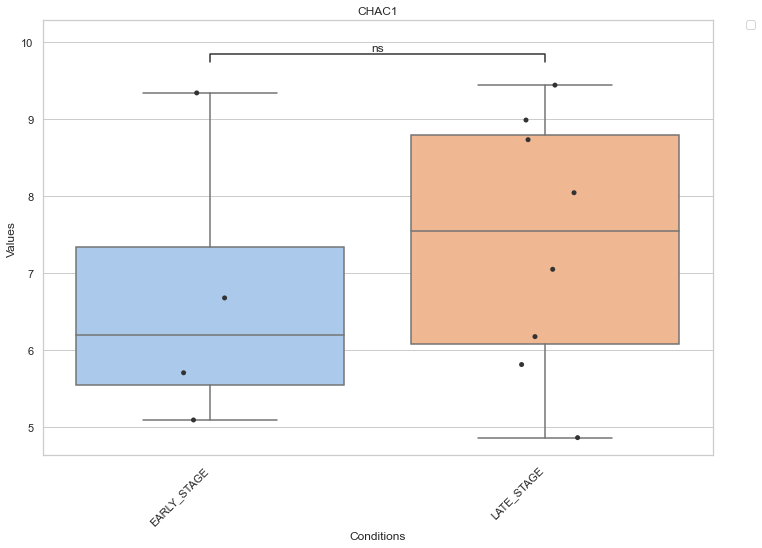

No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EARLY_STAGE v.s. LATE_STAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.066e-01 U_stat=6.000e+00


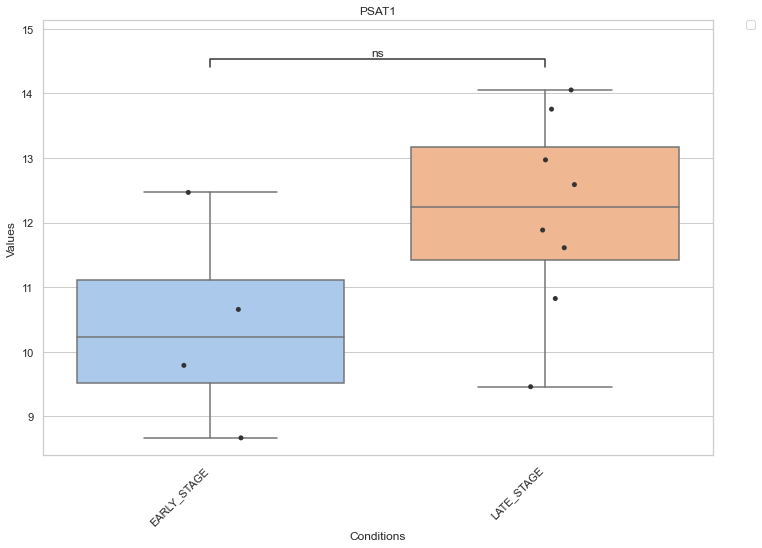

NRF2


No handles with labels found to put in legend.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EARLY_STAGE v.s. LATE_STAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.080e-02 U_stat=4.000e+00


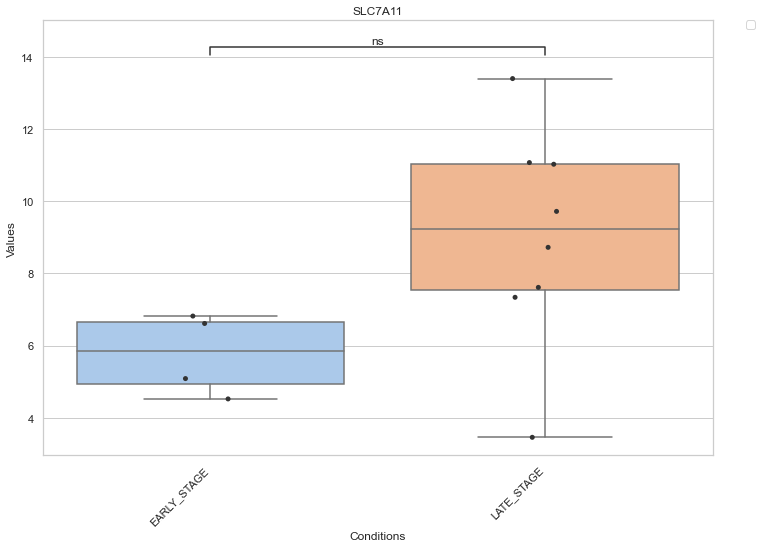

In [14]:
from sciviso import Boxplot
import matplotlib.pyplot as plt
import pandas as pd

df = api.get_rna_df()
df = bm.add_gene_metadata_to_df(df, False)
print(df['gene_id'].values)
filter_col = 'ssm.consequence.0.transcript.gene.symbol'
column_returned = "case_id"
genes_of_interest = ['FH', 'MET', 'ATF4', 'CHAC1', 'PSAT1', 'NRF2', 'SLC7A11']
# Now we have our genes we want these to be our x axis
female_stage1 = api.get_cases_with_meta({'gender': ['female'], 'tumor_stage_num': [1, 2], 'project_id': ['TCGA-KIRP']})
female_stage4 = api.get_cases_with_meta({'gender': ['female'], 'tumor_stage_num': [3, 4], 'project_id': ['TCGA-KIRP']})

# Lets log2 + 1 the data 
transformed_df = pd.DataFrame()

values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', female_stage4)
print(filtered_df.shape)
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['LATE_STAGE' + c] = np.log2(filtered_df[c].values + 1)
    
values, columns, filtered_df = api.get_values_from_df(df, 'gene_id', female_stage1)
for c in columns:
    if c != 'gene_id' and 'TCGA' in c:
        transformed_df['EARLY_STAGE' + c] = np.log2(filtered_df[c].values + 1)

transformed_df['gene_id'] = df['gene_id'].values

# Lets get the values for these cases 
# Cool we have 56 and 19 that's enough for a statistical sig let's see if any of our genes are interesting
for gene in genes_of_interest:
    try:
        boxplot = Boxplot(transformed_df, None, None)
        box_df = boxplot.format_data_for_boxplot(transformed_df, ['EARLY_STAGE', 'LATE_STAGE'], "gene_id", [gene])
        boxplot = Boxplot(box_df, "Conditions", "Values", gene, add_dots=True)
        boxplot.plot()
        plt.show()
    except:
        print(gene)